In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("slk.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [9]:
deu_eng = deu_eng[:50000,:2]

In [46]:
deu_eng.shape

(9842, 2)

In [12]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Choď'],
       ['Go', 'Choďte'],
       ['Go', 'Iď'],
       ...,
       ['Ill be playing tennis with Tom this afternoon but its not something Im really looking forward to',
        'Dnes poobede budem hrať tenis s Tomom ale nie je to niečo na čo by som sa skutočne tešil'],
       ['My breakfast usually consists of coffee with milk a piece of bread and jam a small banana a piece of orange and some dried plums',
        'Moje raňajky zvyčajne pozostávajú z kávy s mliekom kúska chlebíka s džemom banánika kúska pomaranča a sušených sliviek'],
       ['When writing a sentence generally you start with a capital letter and finish with a period  an exclamation mark  or a question mark ',
        'Pri písaní vety sa zvyčajne začína s veľkým písmenom a končí bodkou  výkričníkom  alebo otáznikom ']],
      dtype='<U145')

In [13]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'choď'],
       ['go', 'choďte'],
       ['go', 'iď'],
       ...,
       ['ill be playing tennis with tom this afternoon but its not something im really looking forward to',
        'dnes poobede budem hrať tenis s tomom ale nie je to niečo na čo by som sa skutočne tešil'],
       ['my breakfast usually consists of coffee with milk a piece of bread and jam a small banana a piece of orange and some dried plums',
        'moje raňajky zvyčajne pozostávajú z kávy s mliekom kúska chlebíka s džemom banánika kúska pomaranča a sušených sliviek'],
       ['when writing a sentence generally you start with a capital letter and finish with a period  an exclamation mark  or a question mark ',
        'pri písaní vety sa zvyčajne začína s veľkým písmenom a končí bodkou  výkričníkom  alebo otáznikom ']],
      dtype='<U145')

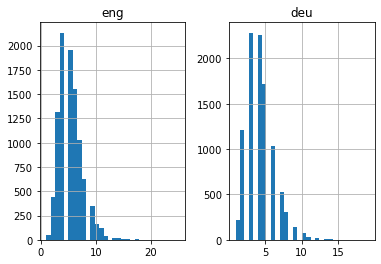

In [14]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [15]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 12
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3201


In [17]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 12
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 6450


In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [19]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [20]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [50]:
trainY[0:50]

array([[   2, 2486,    5,    9,    8,  123,    0,    0,    0,    0,    0,
           0],
       [  36,  188,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   2,  101,   70,   47,  114,  178,    0,    0,    0,    0,    0,
           0],
       [   2,  224,    3,   12,    4,  362,    0,    0,    0,    0,    0,
           0],
       [   3,    6,  320,    7,  353,  466,   92,    2,   86,    0,    0,
           0],
       [  17,  271,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   4,  274,  465,  204,  394,    0,    0,    0,    0,    0,    0,
           0],
       [  10,  280,   56,   89,   31,    1,    0,    0,    0,    0,    0,
           0],
       [  45,   18,    1,  395,    7, 1209,    0,    0,    0,    0,    0,
           0],
       [   2, 1210, 1211,   70,    0,    0,    0,    0,    0,    0,    0,
           0],
       [  27,   88,  644,   47,   10,    0,    0,    0,    0,    0,    0,
           0],
       [   9,  912,  

In [24]:
model = Sequential([
    Embedding(deu_vocab_size, 512, input_length=deu_length, mask_zero=True),
    LSTM(512),
    RepeatVector(eng_length),
    LSTM(512, return_sequences=True),
    Dense(eng_vocab_size, activation='softmax')
])

In [30]:
rms = 'adam'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [31]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
13/13 [==============================] - 32s 213ms/step - loss: 7.2572 - val_loss: 3.6464

Epoch 00001: val_loss improved from inf to 3.64636, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
Epoch 2/30
13/13 [==============================] - 1s 60ms/step - loss: 3.5035 - val_loss: 3.3108

Epoch 00002: val_loss improved from 3.64636 to 3.31084, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
Epoch 3/30
13/13 [==============================] - 1s 57ms/step - loss: 3.2483 - val_loss: 3.1477

Epoch 00003: val_loss improved from 3.31084 to 3.14767, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
Epoch 4/30
13/13 [==============================] - 1s 60ms/ste

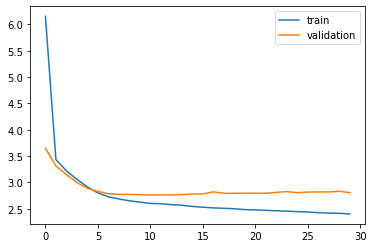

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [35]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\jesse\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [37]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [42]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [43]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
820,he has a lot of books,i you
1859,i wish you couldve met tom,i you to
1504,i am baking bread,i you
1507,hi how are you,i you
1731,tom knew i wasnt going to win,i you to
526,the goods arrived undamaged,i you
1671,how old did you say tom was,i you to
4,toms parents have a lot of money,i you to
77,i promise you ill be there on time,i you to
1662,tom is your teacher,i you


In [1]:
preds

NameError: name 'preds' is not defined